In [ ]:
#Análise de sentimento exercício final

In [1]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import re
import string
import nltk 
from nltk.corpus import stopwords

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

%matplotlib inline
###For downlaod the nltk
########nltk.download()

In [2]:
from bs4 import BeautifulSoup
from gensim.models import word2vec
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm_notebook
import re
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

In [3]:
#Importando os documentos de treino e teste
train = pd.read_csv('C:/Users/Eden/Documents/PUC-MG - Inteligência Artifical e Aprendizado de Máquina/AS/labeledTrainData.tsv',
encoding='latin-1',sep = '\t',low_memory = False)

In [4]:
test = pd.read_csv('C:/Users/Eden/Documents/PUC-MG - Inteligência Artifical e Aprendizado de Máquina/AS/testDataset.tsv',encoding='latin-1', 
                   sep = '\t', low_memory = False)

In [5]:
#visualizar as cinco primeiras linhas
train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [6]:
#visualizar as cinco últimas linhas
train.tail()

,id,sentiment,review
24995,3453_3,0,It seems like more consideration has gone into...
24996,5064_1,0,I don't believe they made this film. Completel...
24997,10905_3,0,"Guy is a loser. Can't get girls, needs to buil..."
24998,10194_3,0,This 30 minute documentary BuÃ±uel made in the...
24999,8478_8,1,I saw this movie as a child and it broke my he...


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


In [8]:
#visualizando os dados agrupados
train.groupby('sentiment').describe().transpose()

sentiment                                                      0  \
id     count                                               12500   
       unique                                              12500   
       top                                                4859_1   
       freq                                                    1   
review count                                               12500   
       unique                                              12432   
       top     How has this piece of crap stayed on TV this l...   
       freq                                                    3   

sentiment                                                      1  
id     count                                               12500  
       unique                                              12500  
       top                                                814_10  
       freq                                                    1  
review count                                               12500  
       unique                                              12472  
       top     Love it, love it, love it! This is another abs...  
       freq                                                    2

In [9]:
#Criando uma nova coluna com o tamanho das strings
train['tamanho'] = train['review'].apply(len)
train.head()

,id,sentiment,review,tamanho
0,5814_8,1,With all this stuff going down at the moment w...,2302
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",946
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,2455
3,3630_4,0,It must be assumed that those who praised this...,2245
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,2233


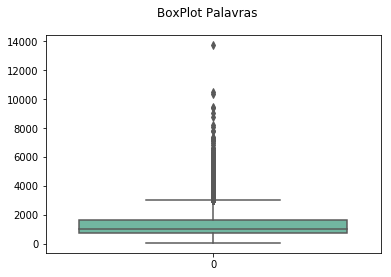

In [10]:
#Criando um box-plot para avaliar a concentração das palavras
fig = plt.figure()
fig.suptitle('BoxPlot Palavras')
sns.boxplot(data=train['tamanho'], orient="v", palette="Set2")

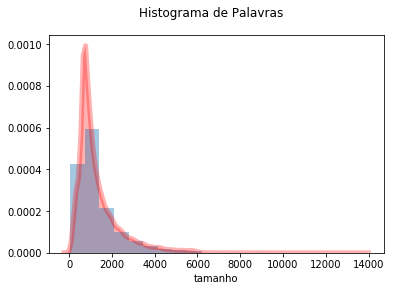

In [11]:
# Histograma de distribuição das palavras
fig = plt.figure()
fig.suptitle('Histograma de Palavras')
sns.distplot( a=train['tamanho'],bins=20, kde=True,
kde_kws={"color": "r", "alpha":0.3, "linewidth": 5, "shade":True })

In [12]:
#Separando os arquivos de treino para os sentimentos  positivos e negativos
positivo = train[(train.sentiment == 0)]
negativo = train[(train.sentiment == 1)]

In [13]:
positivo.head()

,id,sentiment,review,tamanho
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,2455
3,3630_4,0,It must be assumed that those who praised this...,2245
6,7166_2,0,"This movie could have been very good, but come...",605
7,10633_1,0,I watched this video at a friend's house. I'm ...,728
8,319_1,0,"A friend of mine bought this film for Â£1, and...",964


In [14]:
negativo.head()

,id,sentiment,review,tamanho
0,5814_8,1,With all this stuff going down at the moment w...,2302
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",946
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,2233
5,8196_8,1,I dont know why people think this is such a ba...,441
9,8713_10,1,<br /><br />This movie is full of references. ...,245


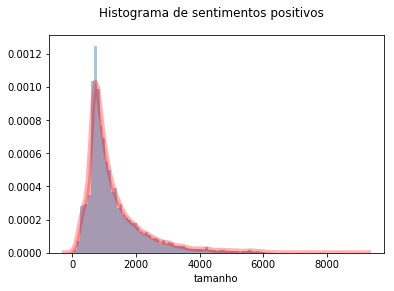

In [15]:
# Histograma sentimento positivo
fig = plt.figure()
fig.suptitle('Histograma de sentimentos positivos')
sns.distplot( a=positivo['tamanho'],bins=100, kde=True,
kde_kws={"color": "r", "alpha":0.3, "linewidth": 5, "shade":True })

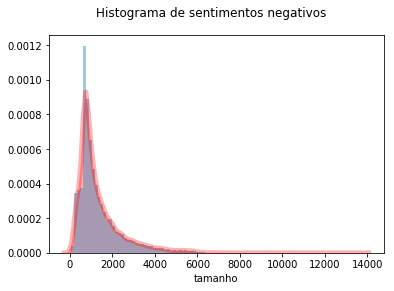

In [16]:
# Histograma sentimento negativo
fig = plt.figure()
fig.suptitle('Histograma de sentimentos negativos')
sns.distplot( a=negativo['tamanho'],bins=100, kde=True,
kde_kws={"color": "r", "alpha":0.3, "linewidth": 5, "shade":True })

In [17]:
#conjunto de stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Eden\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
#função criada para a limpeza dos dados

def clean_text(raw_text):
    raw_text = BeautifulSoup(raw_text).get_text()  #remover as tags html
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text) #remover strings espaços etc
    words = letters_only.lower().split() # converter as palavras em minúsculas e separar por palavras individuais              
    stops = set(stopwords.words("english")) #Criar variável que contém um conjunto de palavras irrelevantes já importado da biblioteca ntlk                
    return [w for w in words if not w in stops] #remover as stopwords

In [19]:
#Revisão, limpeza e também a adição de uma nova coluna como sua contagem de palavras
train['clean_review'] = train['review'].apply(clean_text)
train['tamanho_clean_review'] = train['clean_review'].apply(len)
train.head()

,id,sentiment,review,tamanho,clean_review,tamanho_clean_review
0,5814_8,1,With all this stuff going down at the moment w...,2302,"[stuff, going, moment, mj, started, listening,...",219
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",946,"[classic, war, worlds, timothy, hines, enterta...",84
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,2455,"[film, starts, manager, nicholas, bell, giving...",240
3,3630_4,0,It must be assumed that those who praised this...,2245,"[must, assumed, praised, film, greatest, filme...",189
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,2233,"[superbly, trashy, wondrously, unpretentious, ...",210


In [20]:
#Descrevendo as estatísticas básicas para o conjunto textual
round(train.describe(),3)

,sentiment,tamanho,tamanho_clean_review
count,25000.0,25000.000,25000.000
mean,0.5,1327.954,119.524
std,0.5,1005.550,90.584
min,0.0,52.000,4.000
25%,0.0,703.000,63.000
50%,0.5,981.000,89.000
75%,1.0,1617.000,146.000
max,1.0,13708.000,1416.000


In [21]:
#Comparativo após a limpesa dos dados imprimindo pela pior avaliação
print(train[train['tamanho_clean_review'] == 4]['review'].iloc[0])
print('------Após a limpeza------')
print(train[train['tamanho_clean_review'] == 4]['clean_review'].iloc[0])

This movie is terrible but it has some good effects.
------Após a limpeza------
['movie', 'terrible', 'good', 'effects']


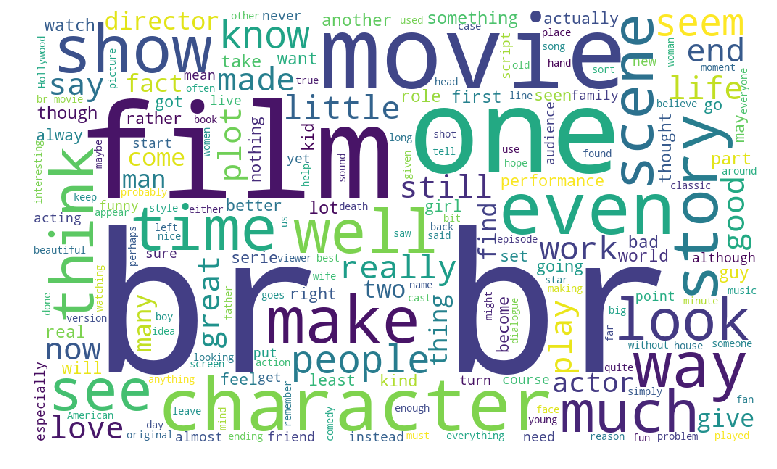

In [22]:
### Word CLoud
#Plotando uma nuvem de palavras para o nosso conjunto de texto
word_cloud = WordCloud(width = 1000, height = 600, stopwords = STOPWORDS, background_color = 'white').generate(
                        ''.join(train['review']))

plt.figure(figsize = (15,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [ ]:
#Nas revisões que foram feitas é preciso aplicar uma lista de  strings específicas, isto é, os modelos de Machine Learning entendem melhor 
#o imput dos dados

#1 - Contar a frequência das palavras (frequência do termo)

#2 - Dar um peso as frequências calculadas

#3 - Normalizaçao do texto original

In [23]:
bow_transf = CountVectorizer(analyzer=clean_text).fit(train['review'])

In [24]:
print(len(bow_transf.vocabulary_))

74065


In [25]:
review1 = train['review'][2]
print(review1)

The film starts with a manager (Nicholas Bell) giving welcome investors (Robert Carradine) to Primal Park . A secret project mutating a primal animal using fossilized DNA, like Â¨Jurassik ParkÂ¨, and some scientists resurrect one of nature's most fearsome predators, the Sabretooth tiger or Smilodon . Scientific ambition turns deadly, however, and when the high voltage fence is opened the creature escape and begins savagely stalking its prey - the human visitors , tourists and scientific.Meanwhile some youngsters enter in the restricted area of the security center and are attacked by a pack of large pre-historical animals which are deadlier and bigger . In addition , a security agent (Stacy Haiduk) and her mate (Brian Wimmer) fight hardly against the carnivorous Smilodons. The Sabretooths, themselves , of course, are the real star stars and they are astounding terrifyingly though not convincing. The giant animals savagely are stalking its prey and the group run afoul and fight against o

In [26]:
bow1 = bow_transf.transform([review1])
print(bow1)
print(bow1.shape)

  (0, 562)	1
  (0, 637)	1
  (0, 1018)	1
  (0, 1078)	1
  (0, 1902)	1
  (0, 2279)	1
  (0, 2350)	1
  (0, 2354)	3
  (0, 2795)	1
  (0, 2902)	1
  (0, 3067)	1
  (0, 3663)	1
  (0, 3811)	1
  (0, 3812)	1
  (0, 4000)	1
  (0, 4131)	1
  (0, 4491)	1
  (0, 5007)	1
  (0, 5287)	1
  (0, 5357)	1
  (0, 5442)	1
  (0, 5573)	1
  (0, 5603)	1
  (0, 5700)	1
  (0, 5705)	1
  :	:
  (0, 64510)	1
  (0, 65109)	1
  (0, 65339)	1
  (0, 65748)	1
  (0, 65829)	2
  (0, 66054)	1
  (0, 66084)	1
  (0, 66740)	1
  (0, 66799)	1
  (0, 67858)	1
  (0, 69765)	1
  (0, 69776)	1
  (0, 70035)	1
  (0, 70506)	1
  (0, 70604)	1
  (0, 70716)	1
  (0, 70806)	1
  (0, 70956)	1
  (0, 71270)	1
  (0, 71566)	1
  (0, 71792)	1
  (0, 72394)	1
  (0, 72883)	1
  (0, 73596)	1
  (0, 73862)	1
(1, 74065)


In [27]:
#criando nova base de dados com a coluna revisão ajustado
review_bow = bow_transf.transform(train['review'])

In [28]:
#Calculo das medidas TF-IDF para preparar os modelos de previsão
tfidf_transf = TfidfTransformer().fit(review_bow)
tfidf1 = tfidf_transf.transform(bow1)

In [29]:
#Visualizando a base gerada
print(tfidf1)

  (0, 73862)	0.08528689788513522
  (0, 73596)	0.0691741583028328
  (0, 72883)	0.041210415418148016
  (0, 72394)	0.09161972406782715
  (0, 71792)	0.05293550045032833
  (0, 71566)	0.057115570752894904
  (0, 71270)	0.05754391499008689
  (0, 70956)	0.08158243204467532
  (0, 70806)	0.0715451400215235
  (0, 70716)	0.04562022505305956
  (0, 70604)	0.08061982287465633
  (0, 70506)	0.04861934709906779
  (0, 70035)	0.0662884193370594
  (0, 69776)	0.03957938379767311
  (0, 69765)	0.04137081437927013
  (0, 67858)	0.03730035820546576
  (0, 66799)	0.0691741583028328
  (0, 66740)	0.03736436082747339
  (0, 66084)	0.06284133212014087
  (0, 66054)	0.08387852533646349
  (0, 65829)	0.053720351280551984
  (0, 65748)	0.0422316478569606
  (0, 65339)	0.07754569915377156
  (0, 65109)	0.04138327019159964
  (0, 64510)	0.032500319603971706
  :	:
  (0, 5705)	0.0715451400215235
  (0, 5700)	0.06005126247803529
  (0, 5603)	0.07691535703419645
  (0, 5573)	0.041661684272670016
  (0, 5442)	0.04845570683925289
  (0, 5357

In [30]:
review_tfidf = tfidf_transf.transform(review_bow)

In [31]:
#Após as devidas transformações é hora de separar os dados de treino e teste
#Modelando e separando o dataset
X_train, X_test, y_train, y_test = train_test_split(train['review'], train['sentiment'], test_size=0.22, random_state=101)

len(X_train), len(X_test), len(X_train) + len(X_test)

(19500, 5500, 25000)

In [32]:
#Importando algumas métricas e criando uma função para as saídas dos modelos
from sklearn.metrics import classification_report
#Predição e estatísticas
def pred(predicted,compare):
    cm = pd.crosstab(compare,predicted)
    TN = cm.iloc[0,0]
    FN = cm.iloc[1,0]
    TP = cm.iloc[1,1]
    FP = cm.iloc[0,1]
    print("Matriz de confusão ------->> ")
    print(cm)
    print()
    
    ##checando a acurácia do modelo
    print('Classificação :------->>')
    print('Nível de Acurácia : ', round(((TP+TN)*100)/(TP+TN+FP+FN),2))
    print()
    print(classification_report(compare,predicted))

In [33]:
#Treinando os modelos
#Regressão Logística
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),  #contagens de números inteiros do token
    ('tfidf', TfidfTransformer()),  #pontuações ponderadas em TF-IDF
    ('classifier', LogisticRegression(random_state=101)),   #treino em vetores TF-IDF com classificador Regressão Logística
])

pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_train)
pred(predictions,y_train)

Matriz de confusão ------->> 
col_0         0     1
sentiment            
0          9042   682
1           499  9277

Classificação :------->>
Nível de Acurácia :  93.94

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      9724
           1       0.93      0.95      0.94      9776

   micro avg       0.94      0.94      0.94     19500
   macro avg       0.94      0.94      0.94     19500
weighted avg       0.94      0.94      0.94     19500



In [34]:
#Resultado no caso de teste Regressão Logística
predictions = pipeline.predict(X_test)
pred(predictions,y_test)

Matriz de confusão ------->> 
col_0         0     1
sentiment            
0          2424   352
1           267  2457

Classificação :------->>
Nível de Acurácia :  88.75

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2776
           1       0.87      0.90      0.89      2724

   micro avg       0.89      0.89      0.89      5500
   macro avg       0.89      0.89      0.89      5500
weighted avg       0.89      0.89      0.89      5500



In [35]:
#Modelo Naive Bayes
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),  #contagens de números inteiros do token
    ('tfidf', TfidfTransformer()),  #pontuações ponderadas em TF-IDF
    ('classifier', MultinomialNB()),  # treino em TF-IDF vetores w/ Naive Bayes classificador
])

pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_train)
pred(predictions,y_train)

Matriz de confusão ------->> 
col_0         0     1
sentiment            
0          9054   670
1           843  8933

Classificação :------->>
Nível de Acurácia :  92.24

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      9724
           1       0.93      0.91      0.92      9776

   micro avg       0.92      0.92      0.92     19500
   macro avg       0.92      0.92      0.92     19500
weighted avg       0.92      0.92      0.92     19500



In [36]:
#Resultado no caso de teste Modelo Naive Baye
predictions = pipeline.predict(X_test)
pred(predictions,y_test)

Matriz de confusão ------->> 
col_0         0     1
sentiment            
0          2423   353
1           352  2372

Classificação :------->>
Nível de Acurácia :  87.18

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2776
           1       0.87      0.87      0.87      2724

   micro avg       0.87      0.87      0.87      5500
   macro avg       0.87      0.87      0.87      5500
weighted avg       0.87      0.87      0.87      5500



In [37]:
#Modelo de Random Forest
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),  #contagens de números inteiros do token
    ('tfidf', TfidfTransformer()),  #pontuações ponderadas em TF-IDF
    ('classifier', RandomForestClassifier(n_estimators = 600)), #treino em TF-IDF vectors w/ RandomForestClassifier
])

pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_train)
pred(predictions,y_train)

Matriz de confusão ------->> 
col_0         0     1
sentiment            
0          9724     0
1             0  9776

Classificação :------->>
Nível de Acurácia :  100.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9724
           1       1.00      1.00      1.00      9776

   micro avg       1.00      1.00      1.00     19500
   macro avg       1.00      1.00      1.00     19500
weighted avg       1.00      1.00      1.00     19500



In [38]:
#Resultado no caso de teste Modelo Random Forest
predictions = pipeline.predict(X_test)
pred(predictions,y_test)

Matriz de confusão ------->> 
col_0         0     1
sentiment            
0          2394   382
1           371  2353

Classificação :------->>
Nível de Acurácia :  86.31

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      2776
           1       0.86      0.86      0.86      2724

   micro avg       0.86      0.86      0.86      5500
   macro avg       0.86      0.86      0.86      5500
weighted avg       0.86      0.86      0.86      5500



In [39]:
#Modelo AdaBoost Classifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),  #contagens de números inteiros do token
    ('tfidf', TfidfTransformer()),  #pontuações ponderadas em TF-IDF
    ('classifier', AdaBoostClassifier(n_estimators=500)),  # treino em TF-IDF vectors w/ SVC
])

pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_train)
pred(predictions,y_train)

Matriz de confusão ------->> 
col_0         0     1
sentiment            
0          8747   977
1           825  8951

Classificação :------->>
Nível de Acurácia :  90.76

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      9724
           1       0.90      0.92      0.91      9776

   micro avg       0.91      0.91      0.91     19500
   macro avg       0.91      0.91      0.91     19500
weighted avg       0.91      0.91      0.91     19500



In [40]:
#Resultado no caso de teste Modelo AdaBoost Classifier
predictions = pipeline.predict(X_test)
pred(predictions,y_test)

Matriz de confusão ------->> 
col_0         0     1
sentiment            
0          2369   407
1           397  2327

Classificação :------->>
Nível de Acurácia :  85.38

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      2776
           1       0.85      0.85      0.85      2724

   micro avg       0.85      0.85      0.85      5500
   macro avg       0.85      0.85      0.85      5500
weighted avg       0.85      0.85      0.85      5500



In [41]:
#Modelo Stochastic Gradient Descent - SGD
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),  #contagens de números inteiros do token
    ('tfidf', TfidfTransformer()),  #pontuações ponderadas em TF-IDF
    ('classifier', SGDClassifier()),  # treino em TF-IDF vetores w/ SGD classifier
])

pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_train)
pred(predictions,y_train)

Matriz de confusão ------->> 
col_0         0     1
sentiment            
0          9249   475
1           488  9288

Classificação :------->>
Nível de Acurácia :  95.06

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      9724
           1       0.95      0.95      0.95      9776

   micro avg       0.95      0.95      0.95     19500
   macro avg       0.95      0.95      0.95     19500
weighted avg       0.95      0.95      0.95     19500



In [42]:
#Resultado no caso de teste Modelo Stochastic Gradient Descent - SGD
predictions = pipeline.predict(X_test)
pred(predictions,y_test)

Matriz de confusão ------->> 
col_0         0     1
sentiment            
0          2485   291
1           274  2450

Classificação :------->>
Nível de Acurácia :  89.73

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2776
           1       0.89      0.90      0.90      2724

   micro avg       0.90      0.90      0.90      5500
   macro avg       0.90      0.90      0.90      5500
weighted avg       0.90      0.90      0.90      5500



In [43]:
#O modelo que teve melhor desempenho foi Stochastic Gradient Descent e é este que iremos usar para realizar a previsão
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

pipeline_logit = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),  #contagens de números inteiros do token
    ('tfidf', TfidfTransformer()),  #pontuações ponderadas em TF-IDF
    ('classifier', SGDClassifier()),  # treino em TF-IDF vetores w/ SGD classifier
])


pipeline_logit.fit(train['review'],train['sentiment'])
test['sentiment'] = pipeline_logit.predict(test['review'])

'''o modelo SGDC foi escolhido por ser um pouco mais eficiente do que os outros modelos para a classificação de textos,
bastante aplicado para o processamento de linguagem natural. As vantagens são sua eficiência na predição, principalmente facilidade 
na implementação, o código pode ser ajustado facilmente. As desvantagens é que o modelo SGD requer vários hiperparâmetros e
número de iterações
   A matriz de confusão para o modelo SGD

'''


In [44]:
test.head(5)

,Id,review,sentiment
0,319_1,"If you are in search of a masochistic thrill, ...",0
1,2486_3,* Some spoilers *<br /><br />This movie is som...,1
2,3561_4,This film is about a grieving wife who lost he...,0
3,9352_10,"What a fine film! Unfortunately, being 1947, t...",1
4,10492_1,Imagine what it must have been like for John A...,0


In [46]:
output = test[['Id','sentiment']]
print(output)

            Id  sentiment
0        319_1          0
1       2486_3          1
2       3561_4          0
3      9352_10          1
4      10492_1          0
5       4656_4          1
6       9727_7          1
7      11241_1          0
8      4005_10          1
9      11885_1          0
10    12106_10          1
11     11427_1          0
12      4221_8          1
13      9983_3          0
14     11289_4          0
15      301_10          1
16      8880_3          0
17      1510_8          0
18    10064_10          1
19     11471_7          1
20      6403_3          0
21      8459_3          0
22    10531_10          1
23     11736_9          1
24     7168_10          1
25     1777_10          1
26    10533_10          0
27      292_10          1
28      5240_1          0
29      3088_8          1
...        ...        ...
7043  11390_10          1
7044    4653_2          0
7045    3238_1          0
7046    3692_1          0
7047    4308_1          0
7048    5937_4          0
7049    2903

In [47]:
#Exportando os arquivos
output_csv = output.to_csv ('C:/Users/Eden/Documents/PUC-MG - Inteligência Artifical e Aprendizado de Máquina/AS/output.csv', index = None, header=True)